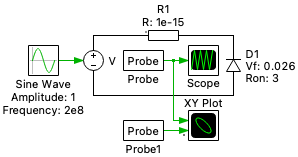

#### A simple, nonlinear circuit model
Originally implemented in PLECS. A resistor and a diode excited with a time harmonic signal (200 MHz).
This model determines the current drawn from the voltage source.

The goal is to use automatic differentiation to calculate $\partial i/\partial v$ which is needed
for the nonlinear Finite Element Method.

In [1]:
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end

import Base: +, -, *, /
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)

import Base: abs, sin, cos, tan, exp, log, sqrt, conj, abs2, isless
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
log(x::Dual)  = Dual(log(x.v), x.dv/x.v)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
conj(x::Dual) = x
abs2(x::Dual) = abs(x) * abs(x)
isless(x::Dual, y::Dual) = x.v < y.v;

import Base: convert, promote_rule
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}

import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ε]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

ε = Dual(0., 1.)

(0.0) + [1.0ε]

In [2]:
mutable struct ElectricDevice{D, T}
    ti :: Int
    it :: Int
    D0 :: Matrix{T}
    D1 :: Matrix{T}
    xp :: Vector{T}
    up :: Vector{T}
    x  :: Vector{T}
    u  :: Vector{T}
    y  :: Vector{T}
end

function ElectricDevice{D, T}(D0, D1) where {D, T}
    N, M = size(D0[:,:])
    device = ElectricDevice{D, T}(
        0, 0, zeros(T, N, M), zeros(T, N, M),
        zeros(T, N), zeros(T, M),
        zeros(T, N), zeros(T, M), zeros(T, M)
    )
    device.D0 .= D0
    device.D1 .= D1
    return device
end

function natPreComm(state)
    if state.ti == 1 return 1 end
    if state.ti == 2 return 2 end
end

function forcedComm(state)
    if state.ti == 1 return 1 end
    if state.ti == 2 return 2 end
end

function natPostComm(state)
    u = state.u
    if state.ti == 1 return (u[1]  < -u[2]) ? 2 : 1 end
    if state.ti == 2 return (u[1]  >=-u[2]) ? 1 : 2 end
end

function update!(state)    
    if state.ti == 1 D = state.D0 end
    if state.ti == 2 D = state.D1 end
    state.y[:] .= D * state.u
end

function init!(state)
    state.ti = 1
    state.it = 0
end

function step!(state, excitation)
    state.u[1] = excitation
    state.u[2] = 0.026
    state.ti = natPreComm(state)
    state.ti = natPostComm(state)
    state.ti = forcedComm(state)
    update!(state)
    state.up .= state.u
end

step! (generic function with 1 method)

In [3]:
D0 = [ 0.0 0.0
      -1.0 0.0]
D1 = [-0.333333333333333204 -0.333333333333333204
      -0.999999999999999667  3.33333333333333261e-16]

d = ElectricDevice{:D, Dual{Float64}}(D0, D1)
init!(d)

t = range(0, 5e-9, step=0.01e-9)
u = zeros(length(t), 2)
y = zeros(length(t), 2)
dydu = zeros(length(t))

for i=1:length(t)
    step!(d, sin(2π * 2e8 * t[i]) .+ ε)
    u[i, :] .= value.(d.u)
    y[i, :] .= value.(d.y)
    dydu[i]  = partials(d.y[1])
end

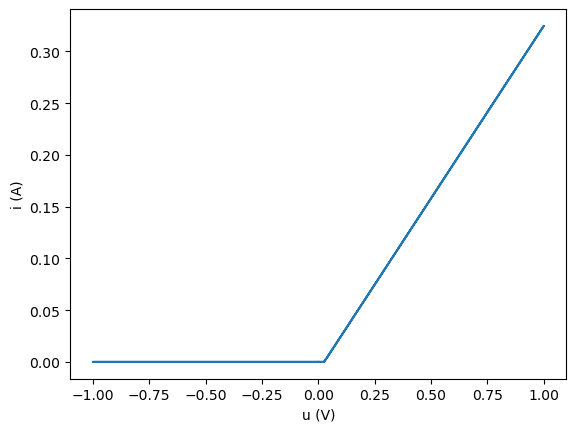

In [4]:
using PyPlot
plot(-u[:, 1], y[:, 1])
xlabel("u (V)")
ylabel("i (A)")
nothing

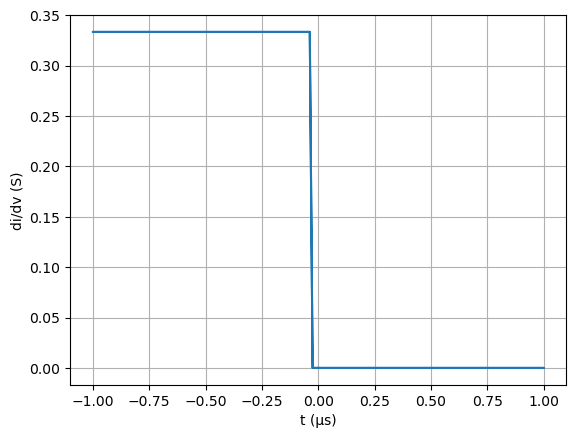

In [5]:
plot(u[:, 1], -dydu[:, 1])
xlabel("t (μs)")
ylabel("di/dv (S)")
grid();

In [6]:
using ACME

cir = @circuit begin
    v  = voltagesource(), [-] == gnd
    i  = currentprobe(),  [-] == gnd
    r1 = resistor(3.00),  [1] == v[+]
    d1 = diode(is=1e-6),  [-] == r1[2], [+] == i[+]
end
nothing

In [7]:
Δt = 0.01e-9
model = DiscreteModel(cir, Δt)
u = [4.0sin(2π * 2e8 * ti) for ti in t]
y = run!(model, [ui for c in 1:1, ui in u])

1×501 Matrix{Float64}:
 0.0  8.66073e-7  9.8206e-7  9.97595e-7  …  -6.46176e-6  -3.9184e-20

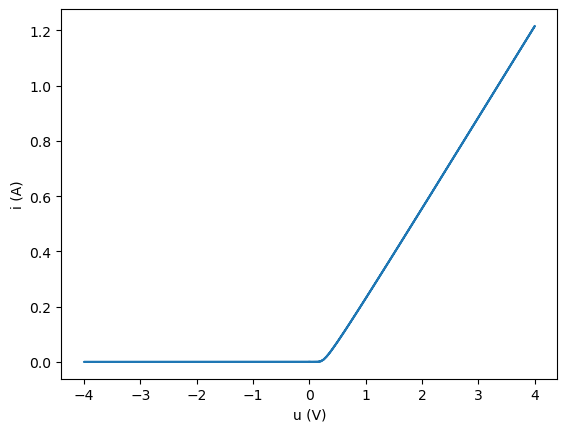

In [8]:
using PyPlot
plot(-u[:], -y[:])
xlabel("u (V)")
ylabel("i (A)")
nothing

In [9]:
include("circuit-model.jl");

A = @SMatrix [0.0]
B = @SMatrix [0.0]
C = @SMatrix [0.0]
Di = @SMatrix [0.0]
_, _, _,  _, Ei, Fi,
_, _, _, Dq, Eq, Fq = matrices(cir, Δt, 2)
x̄, y, ū, q̄, z = states(B, C, Di, Dq; T=Dual{Float64})
nothing

In [10]:
Is1, Is2 = 1e-4,  1e-4
Vt1, Vt2 = 25e-3, 25e-3
f(q) = @SMatrix[(Is1 * exp(q[1]/Vt1) - Is1 - q[2])]
df(q)= @SMatrix[(Is1 / Vt1 * exp(q[1]/Vt1)) -1.0]

df (generic function with 1 method)

In [11]:
m = DifferentiableModel(A, B, C, Di, Ei, Fi, Dq, Eq, Fq, x̄, y, ū, q̄, z)
Δ = 1e-5

ys = similar(t)
us = similar(t)
didv = similar(t)
dydu = similar(t)
for i in 1:length(t)
    x̄ = copy(m.x̄)
    y = copy(m.y)
    ū = copy(m.ū)
    q̄ = copy(m.q̄)
    z = copy(m.z)
    
    step!(m, u[i] + Δ, f, df)
    didv[i] = value(first(m.y))
    
    m.x̄ .= x̄
    m.y .= y
    m.ū .= ū
    m.q̄ .= q̄
    m.z .= z
    
    step!(m, u[i] - Δ, f, df)
    didv[i]-= value(first(m.y))
    
    m.x̄ .= value.(x̄)
    m.y .= value.(y)
    m.ū .= value.(ū)
    m.q̄ .= value.(q̄)
    m.z .= value.(z)
    
    step!(m, u[i] + ε, f, df)
    us[i] = value(first(m.ū))
    ys[i] = value(first(m.y))
    dydu[i] = partials(first(m.y))
    
    didv[i]/= 2Δ
end
#=
for i in 1:length(t)
    _x̄ = copy(x̄)
    _y = copy(y)
    _ū = copy(ū)
    _q̄ = copy(q̄)
    _z = copy(z)
    
    ū .= Δ + u[i]
    step!(m, f, df)
    didv[i] = value(first(y))
    
    x̄ .= value.(_x̄)
    y .= value.(_y)
    ū .= value.(_ū)
    q̄ .= value.(_q̄)
    z .= value.(_z)
    
    ū .= ε + u[i]
    step!(m, f, df)
    us[i] = value(first(ū))
    ys[i] = value(first(y))
    dydu[i] = partials(first(y))
    didv[i]-= value(first(y))
    didv[i]/= Δ
end
=#

Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) +

Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) +

Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) +

Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (0.0) +

Norm after nonlinear iterations: (1.3877787807814457e-17) + [-3.885780586188048e-16ε]
Norm after nonlinear iterations: (4.163336342344337e-17) + [-0.0ε]
Norm after nonlinear iterations: (6.938893903907228e-17) + [-0.0ε]
Norm after nonlinear iterations: (6.938893903907228e-17) + [1.6653345369377348e-16ε]
Norm after nonlinear iterations: (8.326672684688674e-17) + [0.0ε]
Norm after nonlinear iterations: (1.3877787807814457e-16) + [-0.0ε]
Norm after nonlinear iterations: (3.608224830031759e-16) + [-2.7755575615628914e-16ε]
Norm after nonlinear iterations: (0.0) + [NaNε]
Norm after nonlinear iterations: (1.1102230246251565e-16) + [-0.0ε]
Norm after nonlinear iterations: (5.551115123125783e-17) + [2.220446049250313e-16ε]
Norm after nonlinear iterations: (1.3877787807814457e-16) + [-0.0ε]
Norm after nonlinear iterations: (1.942890293094024e-16) + [-0.0ε]
Norm after nonlinear iterations: (5.551115123125783e-17) + [2.7755575615628914e-16ε]
Norm after nonlinear iterations: (1.942890293094024e-16

Norm after nonlinear iterations: (4.440892098500626e-16) + [5.551115123125783e-15ε]
Norm after nonlinear iterations: (1.2878587085651816e-14) + [0.0ε]
Norm after nonlinear iterations: (1.3988810110276972e-14) + [0.0ε]
Norm after nonlinear iterations: (9.103828801926284e-15) + [1.1657341758564144e-15ε]
Norm after nonlinear iterations: (1.7985612998927536e-14) + [-0.0ε]
Norm after nonlinear iterations: (1.9317880628477724e-14) + [0.0ε]
Norm after nonlinear iterations: (1.354472090042691e-14) + [-4.9404924595819466e-15ε]
Norm after nonlinear iterations: (8.43769498715119e-15) + [0.0ε]
Norm after nonlinear iterations: (9.325873406851315e-15) + [0.0ε]
Norm after nonlinear iterations: (7.549516567451064e-15) + [-1.2212453270876722e-15ε]
Norm after nonlinear iterations: (1.3766765505351941e-14) + [-0.0ε]
Norm after nonlinear iterations: (7.105427357601002e-15) + [-0.0ε]
Norm after nonlinear iterations: (6.217248937900877e-15) + [-7.216449660063518e-16ε]
Norm after nonlinear iterations: (2.065

Norm after nonlinear iterations: (5.10702591327572e-15) + [-0.0ε]
Norm after nonlinear iterations: (1.7319479184152442e-14) + [-0.0ε]
Norm after nonlinear iterations: (6.661338147750939e-15) + [-3.885780586188048e-16ε]
Norm after nonlinear iterations: (1.2212453270876722e-14) + [0.0ε]
Norm after nonlinear iterations: (2.6423307986078726e-14) + [0.0ε]
Norm after nonlinear iterations: (5.995204332975845e-15) + [8.326672684688674e-16ε]
Norm after nonlinear iterations: (8.659739592076221e-15) + [0.0ε]
Norm after nonlinear iterations: (2.5757174171303632e-14) + [0.0ε]
Norm after nonlinear iterations: (5.329070518200751e-15) + [-1.1102230246251565e-16ε]
Norm after nonlinear iterations: (7.549516567451064e-15) + [0.0ε]
Norm after nonlinear iterations: (1.4210854715202004e-14) + [-0.0ε]
Norm after nonlinear iterations: (8.215650382226158e-15) + [-1.7208456881689926e-15ε]
Norm after nonlinear iterations: (2.4424906541753444e-15) + [-0.0ε]
Norm after nonlinear iterations: (2.0650148258027912e-14

Norm after nonlinear iterations: (1.9984014443252818e-15) + [-2.6645352591003757e-15ε]
Norm after nonlinear iterations: (4.9960036108132044e-15) + [0.0ε]
Norm after nonlinear iterations: (5.440092820663267e-15) + [-0.0ε]
Norm after nonlinear iterations: (2.55351295663786e-15) + [-1.0547118733938987e-15ε]
Norm after nonlinear iterations: (1.3322676295501878e-15) + [0.0ε]
Norm after nonlinear iterations: (5.551115123125783e-17) + [0.0ε]
Norm after nonlinear iterations: (7.216449660063518e-16) + [-9.43689570931383e-16ε]
Norm after nonlinear iterations: (1.7208456881689926e-15) + [-0.0ε]
Norm after nonlinear iterations: (1.2212453270876722e-15) + [-0.0ε]
Norm after nonlinear iterations: (9.43689570931383e-16) + [1.6653345369377348e-15ε]
Norm after nonlinear iterations: (2.1649348980190553e-15) + [-0.0ε]
Norm after nonlinear iterations: (1.4988010832439613e-15) + [0.0ε]
Norm after nonlinear iterations: (2.7755575615628914e-16) + [-2.3314683517128287e-15ε]
Norm after nonlinear iterations: (1

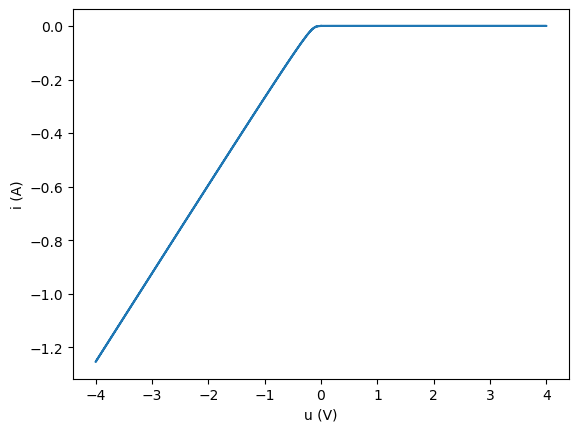

In [12]:
using PyPlot
plot(us[:], ys[:])
xlabel("u (V)")
ylabel("i (A)")
nothing

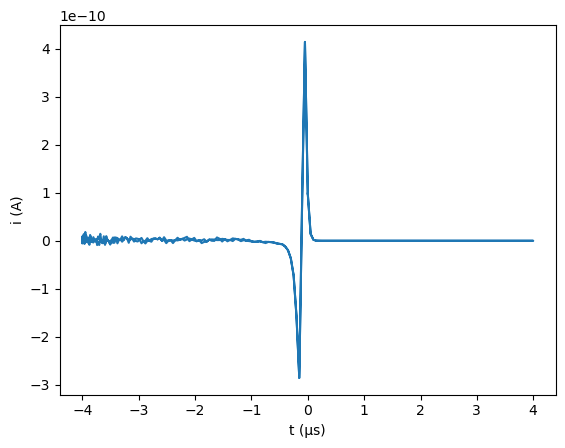

In [13]:
using PyPlot
#plot(us[:], -didv[:])
#plot(us[:], -dydu[:])
plot(us[:], didv[:] .- dydu[:])
xlabel("t (μs)")
ylabel("i (A)")
nothing

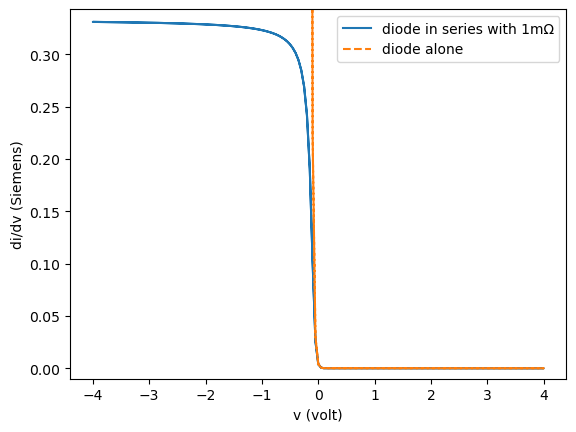

In [14]:
using PyPlot
#plot(us[:], 1.0 .- dydu[:])
plot(us[:], dydu[:])
plot(us[:], Is1 / Vt1 * exp.(-us[:] ./ Vt1),"--")
ylim([-0.01,+1/3.00+0.01])
legend(("diode in series with 1mΩ", "diode alone"))
xlabel("v (volt)")
ylabel("di/dv (Siemens)")
nothing